In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
# This is how I have learned to import files in previous classes - by connecting google to the drive and then getting the file.

Mounted at /content/gdrive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the first file
try:
    df = pd.read_csv('/content/gdrive/MyDrive/DS 5110 Final Project/Data to use/merged_wildfires_data.csv')
    print("Successfully loaded merged_wildfires_data.csv:")
    display(df.head())
except FileNotFoundError:
    print("Error: 'Data_to_use/merged_wildfires_data.csv' not found. Please check the file path and name.")
except Exception as e:
    print(f"An error occurred while loading merged_wildfires_data.csv: {e}")

/tmp/ipython-input-973156782.py:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/gdrive/MyDrive/DS 5110 Final Project/Data to use/merged_wildfires_data.csv')


Successfully loaded merged_wildfires_data.csv:


,DISCOVERY_DATE,CONTAIN_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,COUNTRY,CAUSE
0,2005-02-02,2005-02-02,0.10,A,40.036944,-121.005833,United States,Human
1,2004-05-12,2004-05-12,0.25,A,38.933056,-120.404444,United States,Natural
2,2004-05-31,2004-05-31,0.10,A,38.984167,-120.735556,United States,Human
3,2004-06-28,2004-07-03,0.10,A,38.559167,-119.913333,United States,Natural
4,2004-06-28,2004-07-03,0.10,A,38.559167,-119.933056,United States,Natural


Some testing to ensure this is the correct file

In [3]:
unique_countries = df['COUNTRY'].unique()
print("Unique countries in the dataset:")
print(unique_countries)

Unique countries in the dataset:
['United States' 'Canada']


In [4]:
print(len(df))

2603317


The correct amount of observations is 2603317

In [5]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
DISCOVERY_DATE        4043
CONTAIN_DATE       1068097
FIRE_SIZE                0
FIRE_SIZE_CLASS          0
LATITUDE                 0
LONGITUDE                0
COUNTRY                  0
CAUSE                    0
dtype: int64


Now that the file has been successfully loaded, we can begin the analysis.
First, let us explore the columns. I want to check the date categories since most of them report 00:00.

In [6]:
# Convert date columns to datetime objects, coercing errors to NaT
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce')
df['CONTAIN_DATE'] = pd.to_datetime(df['CONTAIN_DATE'], errors='coerce')

# Extract unique time values, dropping NaT values before extracting time
discovery_time_unique = df['DISCOVERY_DATE'].dropna().dt.time.unique()
contain_time_unique = df['CONTAIN_DATE'].dropna().dt.time.unique()

print("Unique discovery times:")
print(discovery_time_unique)
print("\nUnique containment times:")
print(contain_time_unique)

Unique discovery times:
[datetime.time(0, 0)]

Unique containment times:
[datetime.time(0, 0)]


We can see that all dates are stored with midnight as the time. Not useful.

In [7]:
# Convert date columns to datetime objects, coercing errors to NaT, then extract only the date part
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], errors='coerce').dt.date
df['CONTAIN_DATE'] = pd.to_datetime(df['CONTAIN_DATE'], errors='coerce').dt.date

print("Updated DataFrame with date-only columns:")
display(df.head())

Updated DataFrame with date-only columns:


,DISCOVERY_DATE,CONTAIN_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,COUNTRY,CAUSE
0,2005-02-02,2005-02-02,0.10,A,40.036944,-121.005833,United States,Human
1,2004-05-12,2004-05-12,0.25,A,38.933056,-120.404444,United States,Natural
2,2004-05-31,2004-05-31,0.10,A,38.984167,-120.735556,United States,Human
3,2004-06-28,2004-07-03,0.10,A,38.559167,-119.913333,United States,Natural
4,2004-06-28,2004-07-03,0.10,A,38.559167,-119.933056,United States,Natural


In [8]:
# Ensure date columns are pandas datetime objects for calculation
discovery_dt = pd.to_datetime(df['DISCOVERY_DATE'])
contain_dt = pd.to_datetime(df['CONTAIN_DATE'])

# Calculate duration in days
df['DURATION'] = (contain_dt - discovery_dt).dt.days

# Group by country and calculate the average duration
average_duration_by_country = df.groupby('COUNTRY')['DURATION'].mean().reset_index()

print("Average Wildfire Duration by Country:")
display(average_duration_by_country)

Average Wildfire Duration by Country:


,COUNTRY,DURATION
0,Canada,6.438297
1,United States,1.335505


So we see that Canada, on average, has wildfires last for much longer than in the US. This result is a surpise, and I thus need to immediately check some summary statistics. First though, let us check it by fire size class and country.

In [9]:
# Group by country and wildfire size, and calculate the average duration
average_duration_by_country = df.groupby(['FIRE_SIZE_CLASS','COUNTRY'])['DURATION'].mean().reset_index()

print("Average Wildfire Duration by Country and Fire Size Class:")
display(average_duration_by_country)

Average Wildfire Duration by Country and Fire Size Class:


,FIRE_SIZE_CLASS,COUNTRY,DURATION
0,A,Canada,2.414723
1,A,United States,1.301918
2,B,Canada,4.405049
3,B,United States,0.809920
4,C,Canada,11.211863
5,C,United States,1.341770
6,D,Canada,20.090771
7,D,United States,3.889510
8,E,Canada,26.172492
9,E,United States,6.989760


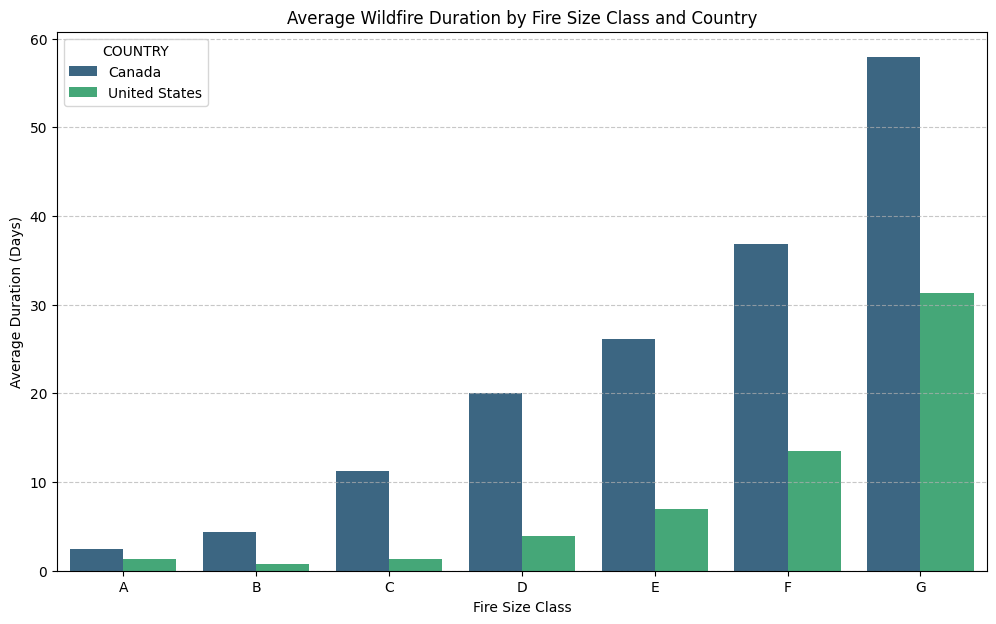

In [10]:
plt.figure(figsize=(12, 7))
sns.barplot(data=average_duration_by_country, x='FIRE_SIZE_CLASS', y='DURATION', hue='COUNTRY', palette='viridis', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Average Wildfire Duration by Fire Size Class and Country')
plt.xlabel('Fire Size Class')
plt.ylabel('Average Duration (Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I should to check the wildfire size class by country and distribution

In [11]:
# Compare FIRE_SIZE statistics by COUNTRY
print("Fire Size Statistics by Country:")
display(df.groupby('COUNTRY')['FIRE_SIZE'].describe())

# Compare FIRE_SIZE_CLASS distribution by COUNTRY
print("\nFire Size Class Distribution by Country:")
fire_size_class_distribution = df.groupby('COUNTRY')['FIRE_SIZE_CLASS'].value_counts(normalize=True).unstack(fill_value=0)
display(fire_size_class_distribution)


Fire Size Statistics by Country:


,count,mean,std,min,25%,50%,75%,max
COUNTRY,,,,,,,,
Canada,436564.0,869.462701,15551.118901,0.00000,0.2471,0.2471,2.7181,2594550.0
United States,2166753.0,75.990398,2536.041295,0.00001,0.1000,0.9700,3.0000,662700.0



Fire Size Class Distribution by Country:


FIRE_SIZE_CLASS,A,B,C,D,E,F,G
COUNTRY,,,,,,,
Canada,0.518978,0.329276,0.076804,0.020732,0.017761,0.018222,0.018226
United States,0.374152,0.483568,0.113648,0.014889,0.007489,0.004198,0.002056


In [47]:
print(len(df[df['FIRE_SIZE_CLASS']=='G']))

12412


Note the quartiles for canada. This likely is due to the conversion from Hectacres to Acres (Hectacres * 2.471 = Acres).

What has happened here is that Canada likely saves small wildfires as 0.1 Hectacres, which makes up the bulk if the data.

Remember, Class A is wildfires < 0.26 Acres, and Class G is wildfires  >= 5000 Acres. The earlier in the alphabet the letter, the smaller the fire.

With this in mind, it seems unlikely that we will find much value in the smaller wildfires. Instead, I shall limit the dataset to D-G, or minimum 100 acres. It can be limited further if desired.

Before that though, I really should check out cause and its distrubition.

In [12]:
# Define the desired column order
desired_order = ['Human', 'Natural', 'Missing data/not specified/undetermined']

In [13]:
# Compare Cause statistics by COUNTRY
print("Cause Statistics by Country:")
fire_size_class_distribution = df.groupby('COUNTRY')['CAUSE'].value_counts(normalize=True).unstack(fill_value=0)

# Reindex the DataFrame with the desired column order
# Ensure all desired columns exist in the DataFrame before reindexing
existing_columns = [col for col in desired_order if col in fire_size_class_distribution.columns]
fire_size_class_distribution = fire_size_class_distribution[existing_columns]

display(fire_size_class_distribution)


Cause Statistics by Country:


CAUSE,Human,Natural,Missing data/not specified/undetermined
COUNTRY,,,
Canada,0.541133,0.434358,0.024510
United States,0.775380,0.144367,0.080253


Now, let us groupby country, then class and check out the cause

In [14]:
fire_cause_distribution_by_country_and_size = df.groupby(['COUNTRY', 'FIRE_SIZE_CLASS'])['CAUSE'].value_counts(normalize=True).unstack(fill_value=0)

# Reindex the DataFrame with the desired column order
# Ensure all desired columns exist in the DataFrame before reindexing
existing_columns = [col for col in desired_order if col in fire_cause_distribution_by_country_and_size.columns]
fire_cause_distribution_by_country_and_size = fire_cause_distribution_by_country_and_size[existing_columns]

display(fire_cause_distribution_by_country_and_size)

CAUSE                             Human   Natural  \
COUNTRY       FIRE_SIZE_CLASS                       
Canada        A                0.557442  0.428381   
              B                0.576271  0.388445   
              C                0.543364  0.423889   
              D                0.421942  0.539056   
              E                0.323188  0.639670   
              F                0.209051  0.748209   
              G                0.112480  0.845168   
United States A                0.708904  0.210425   
              B                0.827600  0.091870   
              C                0.807518  0.112115   
              D                0.723784  0.205046   
              E                0.622974  0.304184   
              F                0.487853  0.442673   
              G                0.330415  0.622222   

CAUSE                          Missing data/not specified/undetermined  
COUNTRY       FIRE_SIZE_CLASS                                           
Canada        A                                               0.014177  
              B                                               0.035283  
              C                                               0.032747  
              D                                               0.039001  
              E                                               0.037142  
              F                                               0.042740  
              G                                               0.042353  
United States A                                               0.080672  
              B                                               0.080530  
              C                                               0.080366  
              D                                               0.071170  
              E                                               0.072842  
              F                                               0.069473  
              G                                               0.047363

<Figure size 1600x800 with 0 Axes>

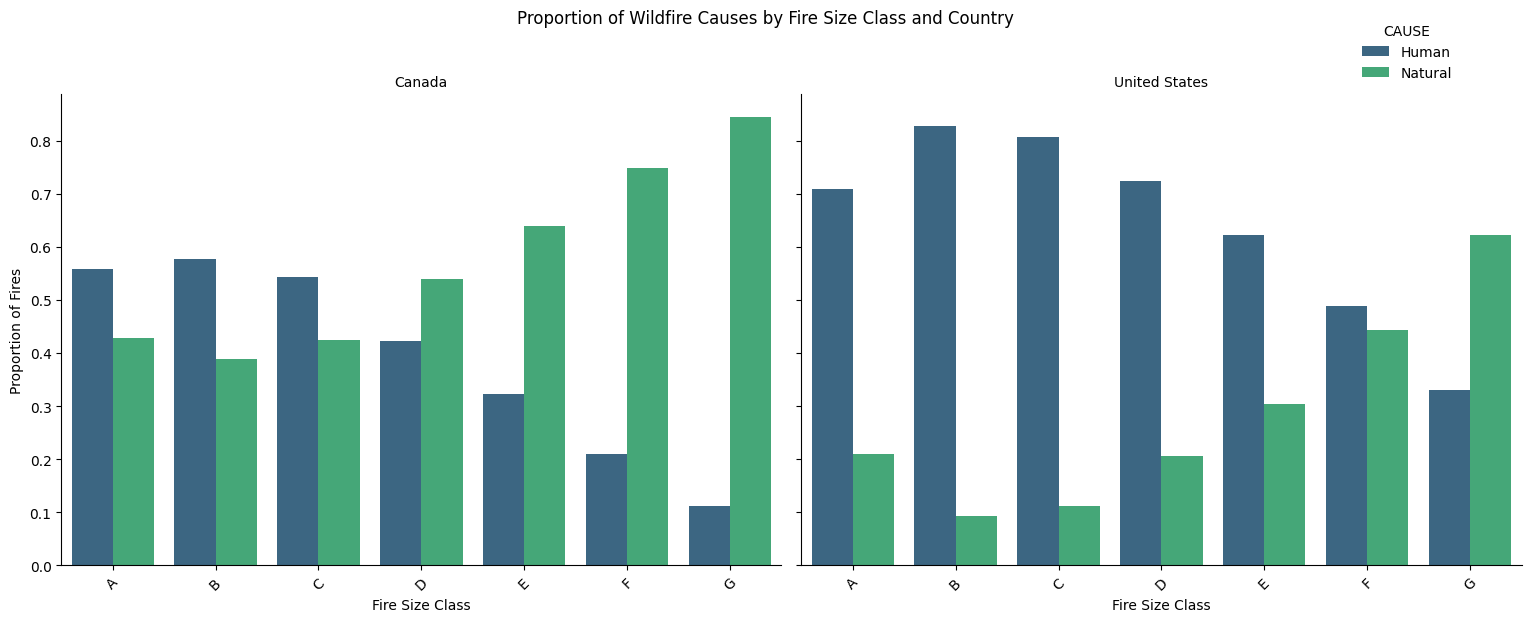

In [15]:
# Reset index to make COUNTRY and FIRE_SIZE_CLASS regular columns
df_plot = fire_cause_distribution_by_country_and_size.reset_index()

# Melt the DataFrame to long format for plotting
df_melted = df_plot.melt(id_vars=['COUNTRY', 'FIRE_SIZE_CLASS'],
                         var_name='CAUSE',
                         value_name='Proportion')

# Filtered out missing, as it really didn't do much when included
df_melted = df_melted[df_melted['CAUSE'] != 'Missing data/not specified/undetermined']

plt.figure(figsize=(16, 8))
g = sns.catplot(data=df_melted,
                x='FIRE_SIZE_CLASS',
                y='Proportion',
                hue='CAUSE',
                col='COUNTRY',
                kind='bar',
                palette='viridis',
                order=['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                height=6, aspect=1.2)

g.set_axis_labels("Fire Size Class", "Proportion of Fires")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.fig.suptitle('Proportion of Wildfire Causes by Fire Size Class and Country', y=1.03) # Adjust title position
g.legend.set_bbox_to_anchor((0.95, 0.95))
plt.tight_layout()
plt.show()

There are some takeaways here. Both countries have similar levels of missing data. The US has a greater proportion of human-caused wildfires compared to Canada, who has more natural-caused wildfires. However, what is consistent about both is that the larger the file (by class), the more likely it is to be from natural causes.

Now that I have explored the datasets, I feel it is time to make the graphs to help explain the situation. I am happy with the tables here to explain the cause of wildfires, but I want some graphs.

Before that though, I want to make a month column and a year column and put it in the dataset. This will be useful later in my models.

In [16]:
df_ex = df.copy()

# Convert date columns to datetime objects, coercing errors to NaT
df_ex['DISCOVERY_DATE'] = pd.to_datetime(df_ex['DISCOVERY_DATE'], errors='coerce')
df_ex['CONTAIN_DATE'] = pd.to_datetime(df_ex['CONTAIN_DATE'], errors='coerce')

# Extract month and year
df_ex['START_MONTH'] = df_ex['DISCOVERY_DATE'].dt.month
df_ex['START_YEAR'] = df_ex['DISCOVERY_DATE'].dt.year
df_ex['END_MONTH'] = df_ex['CONTAIN_DATE'].dt.month
df_ex['END_YEAR'] = df_ex['CONTAIN_DATE'].dt.year

# Calculate duration in days for df_ex
df_ex['DURATION'] = (df_ex['CONTAIN_DATE'] - df_ex['DISCOVERY_DATE']).dt.days

# Drop original date columns as they were dropped previously
df_ex = df_ex.drop('DISCOVERY_DATE', axis=1)
df_ex = df_ex.drop('CONTAIN_DATE', axis=1)

print("New DataFrame 'df_ex' with 'MONTH', 'YEAR', and 'DURATION' columns created:")
display(df_ex.head())

New DataFrame 'df_ex' with 'MONTH', 'YEAR', and 'DURATION' columns created:


,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,COUNTRY,CAUSE,DURATION,START_MONTH,START_YEAR,END_MONTH,END_YEAR
0,0.10,A,40.036944,-121.005833,United States,Human,0.0,2.0,2005.0,2.0,2005.0
1,0.25,A,38.933056,-120.404444,United States,Natural,0.0,5.0,2004.0,5.0,2004.0
2,0.10,A,38.984167,-120.735556,United States,Human,0.0,5.0,2004.0,5.0,2004.0
3,0.10,A,38.559167,-119.913333,United States,Natural,5.0,6.0,2004.0,7.0,2004.0
4,0.10,A,38.559167,-119.933056,United States,Natural,5.0,6.0,2004.0,7.0,2004.0


Recall that duration is in days. Speaking of which, I should do some analysis on that.

In [17]:
# Proportion of wildfires lasting over 10 days by FIRE_SIZE_CLASS
long_fires_10_days = df_ex[df_ex['DURATION'] > 10]
proportion_10_days = long_fires_10_days.groupby('FIRE_SIZE_CLASS').size() / df_ex.groupby('FIRE_SIZE_CLASS').size()
print("\nProportion of wildfires lasting over 10 days by Fire Size Class:")
display(proportion_10_days.fillna(0).sort_index())


# Proportion of wildfires lasting over 100 days by FIRE_SIZE_CLASS
long_fires_100_days = df_ex[df_ex['DURATION'] > 100]
proportion_100_days = long_fires_100_days.groupby('FIRE_SIZE_CLASS').size() / df_ex.groupby('FIRE_SIZE_CLASS').size()
print("\nProportion of wildfires lasting over 100 days by Fire Size Class:")
display(proportion_100_days.fillna(0).sort_index())

# Proportion of wildfires lasting over 365 days by FIRE_SIZE_CLASS
long_fires_365_days = df_ex[df_ex['DURATION'] > 365]
proportion_365_days = long_fires_365_days.groupby('FIRE_SIZE_CLASS').size() / df_ex.groupby('FIRE_SIZE_CLASS').size()
print("\nProportion of wildfires lasting over 365 days by Fire Size Class:")
display(proportion_365_days.fillna(0).sort_index())


Proportion of wildfires lasting over 10 days by Fire Size Class:


,0
FIRE_SIZE_CLASS,
A,0.010337
B,0.009293
C,0.026918
D,0.093581
E,0.181936
F,0.313512
G,0.515549



Proportion of wildfires lasting over 100 days by Fire Size Class:


,0
FIRE_SIZE_CLASS,
A,0.000557
B,0.000464
C,0.001015
D,0.003389
E,0.006922
F,0.017183
G,0.051402



Proportion of wildfires lasting over 365 days by Fire Size Class:


,0
FIRE_SIZE_CLASS,
A,0.000112
B,0.000048
C,0.000111
D,0.000242
E,0.000250
F,0.000059
G,0.000564


We can see that larger fires lasted more days. In particular, 50% of wildfires in class G lasted 10 days or more.

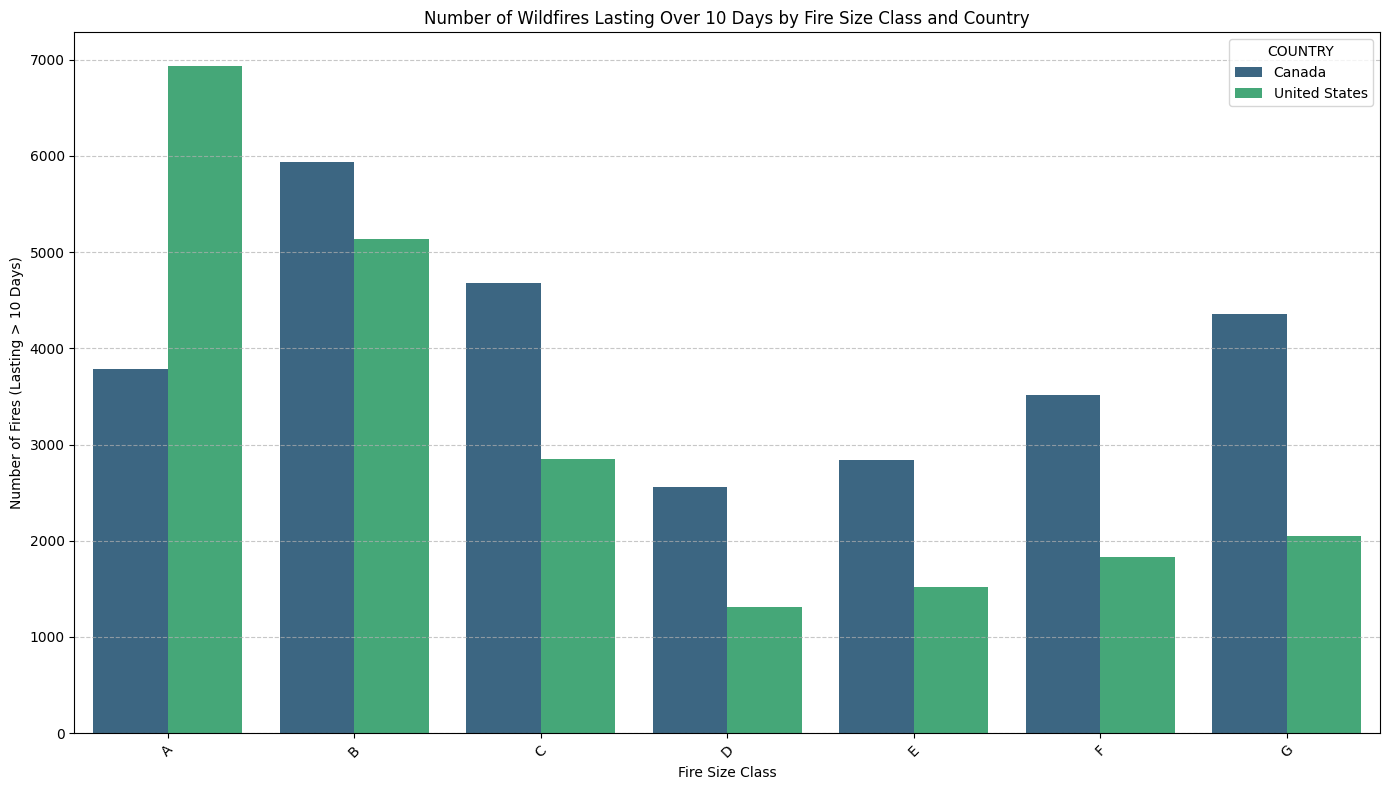

In [18]:
# Count the number of fires by FIRE_SIZE_CLASS and COUNTRY
fires_over_10_days_count = long_fires_10_days.groupby(['FIRE_SIZE_CLASS', 'COUNTRY']).size().reset_index(name='Number of Fires')

plt.figure(figsize=(14, 8))
sns.barplot(data=fires_over_10_days_count, x='FIRE_SIZE_CLASS', y='Number of Fires', hue='COUNTRY', palette='viridis', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Number of Wildfires Lasting Over 10 Days by Fire Size Class and Country')
plt.xlabel('Fire Size Class')
plt.ylabel('Number of Fires (Lasting > 10 Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

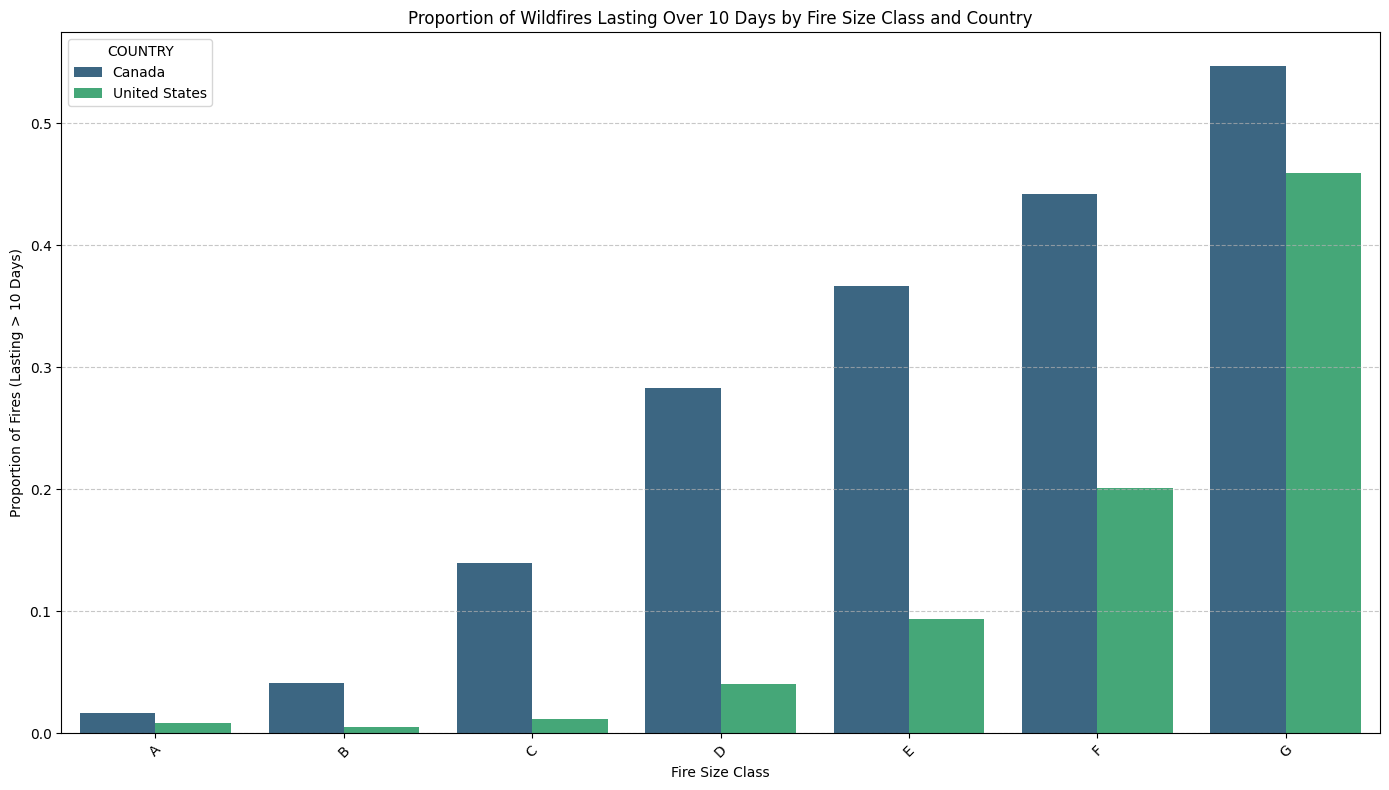

In [19]:
# Calculate the total number of fires for each FIRE_SIZE_CLASS and COUNTRY
total_fires_by_country_size = df_ex.groupby(['FIRE_SIZE_CLASS', 'COUNTRY']).size()

# Calculate the number of long fires (over 10 days) for each FIRE_SIZE_CLASS and COUNTRY
long_fires_by_country_size = long_fires_10_days.groupby(['FIRE_SIZE_CLASS', 'COUNTRY']).size()

# Calculate the proportion
proportion_long_fires = (long_fires_by_country_size / total_fires_by_country_size).fillna(0).reset_index(name='Proportion of Fires')

plt.figure(figsize=(14, 8))
sns.barplot(data=proportion_long_fires, x='FIRE_SIZE_CLASS', y='Proportion of Fires', hue='COUNTRY', palette='viridis', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Proportion of Wildfires Lasting Over 10 Days by Fire Size Class and Country')
plt.xlabel('Fire Size Class')
plt.ylabel('Proportion of Fires (Lasting > 10 Days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The difference between the proportion the number of fires is very interesting. Needs a write up, a perfect fit for the slides/report.

Next, let us plot the number of fires per month.

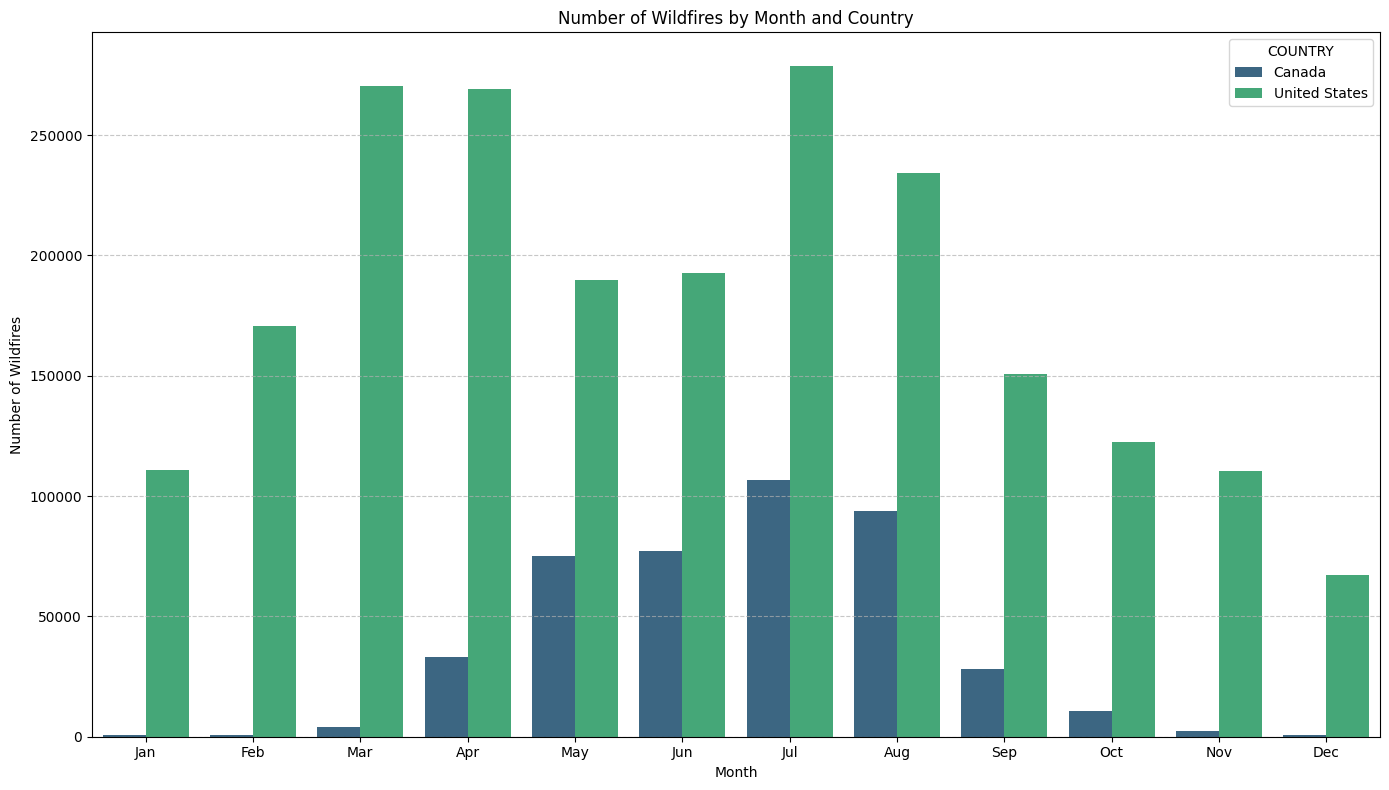

In [20]:
# Prepare data for Chart 1: Number of wildfires per month by country
wildfires_by_month_country = df_ex.groupby(['START_MONTH', 'COUNTRY']).size().reset_index(name='Number of Wildfires')

plt.figure(figsize=(14, 8))
sns.barplot(data=wildfires_by_month_country, x='START_MONTH', y='Number of Wildfires', hue='COUNTRY', palette='viridis')
plt.title('Number of Wildfires by Month and Country')
plt.xlabel('Month')
plt.ylabel('Number of Wildfires')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

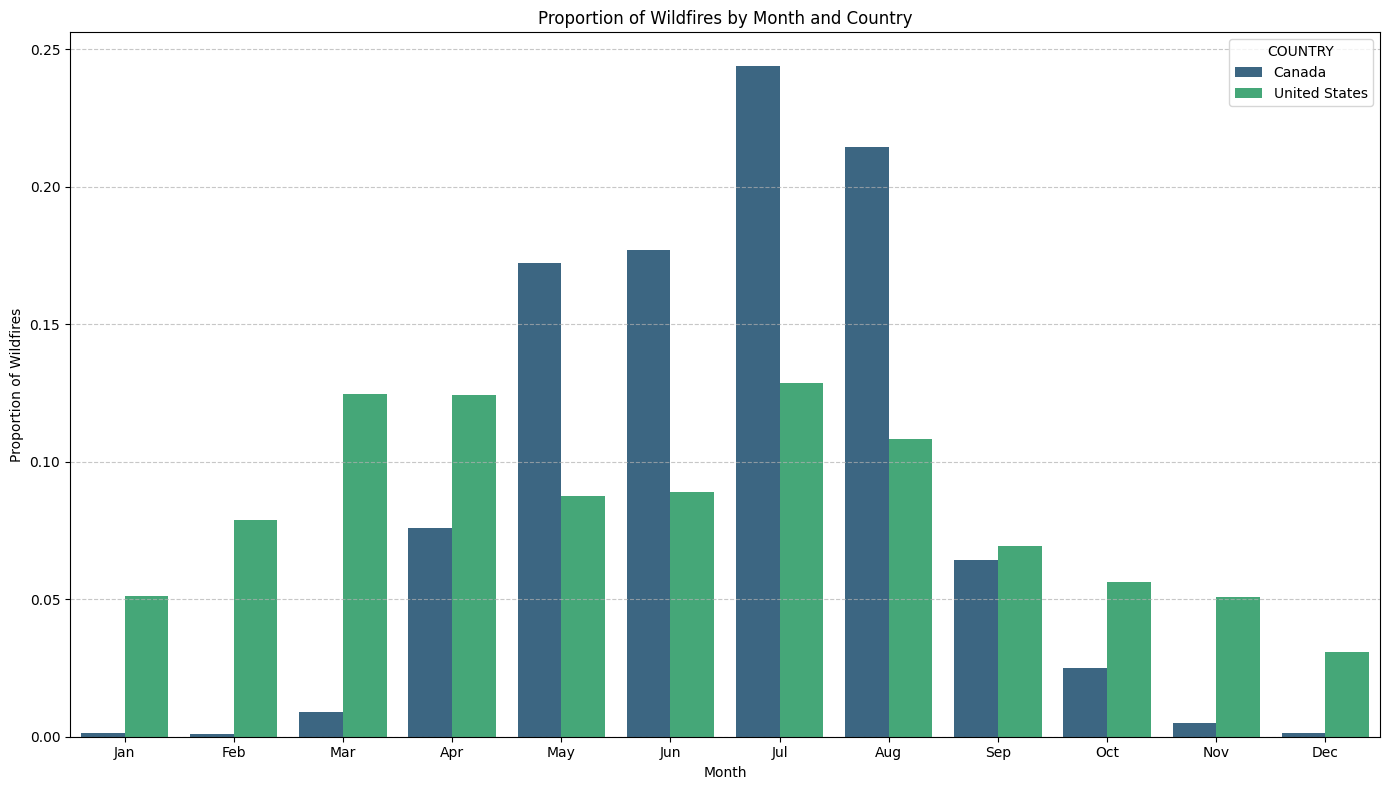

In [21]:
# Prepare data for Chart 2: Proportion of wildfires per month by country

# Calculate total wildfires per country
total_wildfires_per_country = df_ex.groupby('COUNTRY').size()

# Calculate monthly wildfires per country
monthly_wildfires_per_country = df_ex.groupby(['START_MONTH', 'COUNTRY']).size()

# Calculate proportion
proportion_wildfires_by_month_country = (monthly_wildfires_per_country / total_wildfires_per_country).reset_index(name='Proportion of Wildfires')

plt.figure(figsize=(14, 8))
sns.barplot(data=proportion_wildfires_by_month_country, x='START_MONTH', y='Proportion of Wildfires', hue='COUNTRY', palette='viridis')
plt.title('Proportion of Wildfires by Month and Country')
plt.xlabel('Month')
plt.ylabel('Proportion of Wildfires')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We can see that the US has a more consistent spread of wildfires throughout the year, increasing in summmer months and decreasing in winter months. Canada is similar but more extreme. The March - June stretch is worth commenting on though - as it doesn't line up as one may expect.

The last bit of exploration left (that I can think of as typing this) is to plot the years, showing the total number of wildfires. A line graph should work here. First though, I should make a table of the values.

In [22]:
wildfires_by_year_country = df_ex.groupby(['START_YEAR', 'COUNTRY']).size().reset_index(name='Number of Wildfires')

# Setting the year to an int value
wildfires_by_year_country['START_YEAR'] = wildfires_by_year_country['START_YEAR'].astype(int)

display(wildfires_by_year_country)

,START_YEAR,COUNTRY,Number of Wildfires
0,1930,Canada,1
1,1946,Canada,19
2,1947,Canada,26
3,1948,Canada,19
4,1949,Canada,11
...,...,...,...
102,2020,Canada,4015
103,2021,Canada,6709
104,2022,Canada,5368
105,2023,Canada,6835


In [23]:
display(wildfires_by_year_country[wildfires_by_year_country['COUNTRY'] != 'Canada'])

,START_YEAR,COUNTRY,Number of Wildfires
48,1992,United States,67961
50,1993,United States,61972
52,1994,United States,75935
54,1995,United States,71440
56,1996,United States,75561
58,1997,United States,61442
60,1998,United States,68356
62,1999,United States,89350
64,2000,United States,96397
66,2001,United States,87001


Let's check out the number of years with more than 1000 entries, then 10000.

In [24]:
print(len(wildfires_by_year_country[wildfires_by_year_country['Number of Wildfires'] > 1000]))
print(len(wildfires_by_year_country[wildfires_by_year_country['Number of Wildfires'] > 10000]))

100
32


So out of 107 rows, 100 of them have over 1000 wildfires, and 32 have over 10000.

Before restricting the models, let us plot the counts for each country.

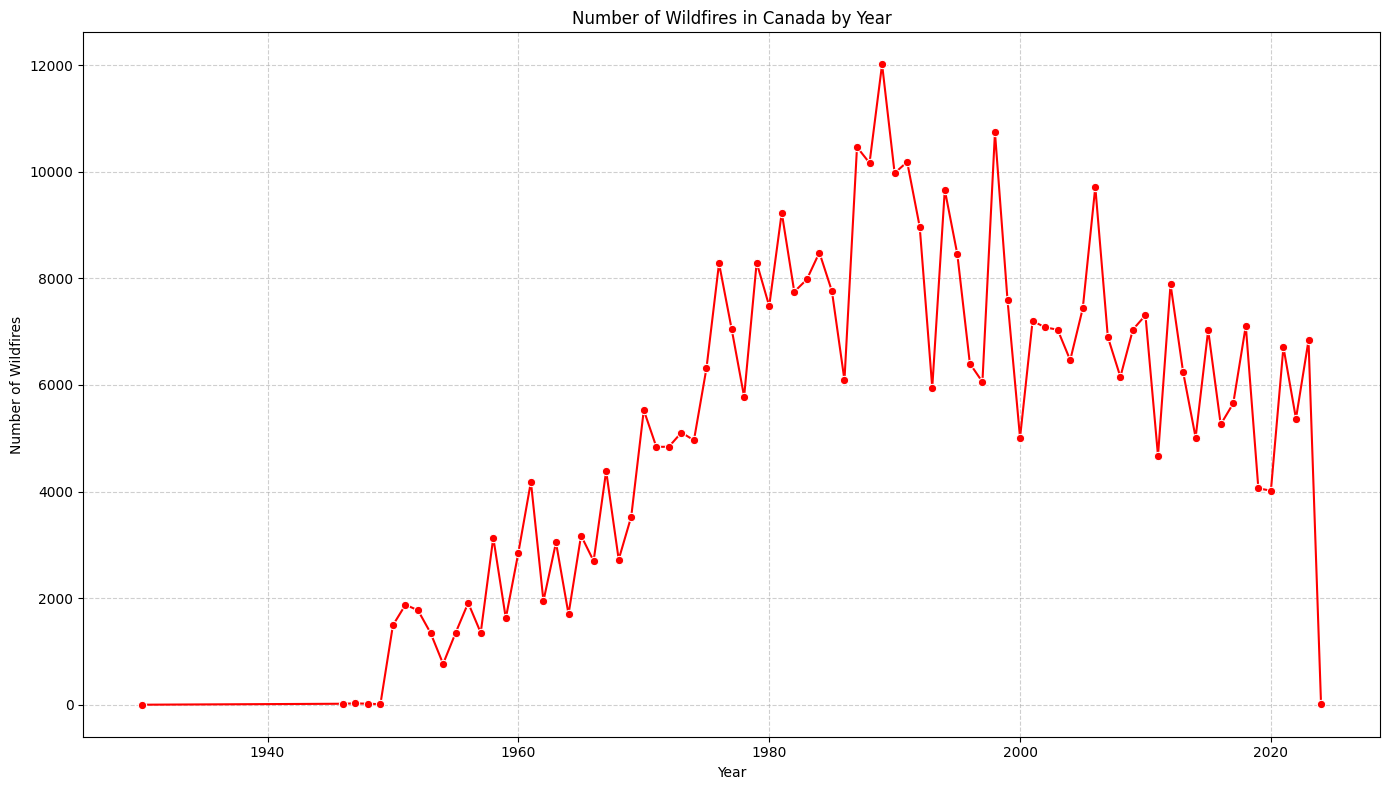

In [25]:
# Filter data for Canada only
canada_wildfires_by_year = wildfires_by_year_country[wildfires_by_year_country['COUNTRY'] == 'Canada']

plt.figure(figsize=(14, 8))
sns.lineplot(data=canada_wildfires_by_year, x='START_YEAR', y='Number of Wildfires', marker='o', color='red')
plt.title('Number of Wildfires in Canada by Year')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

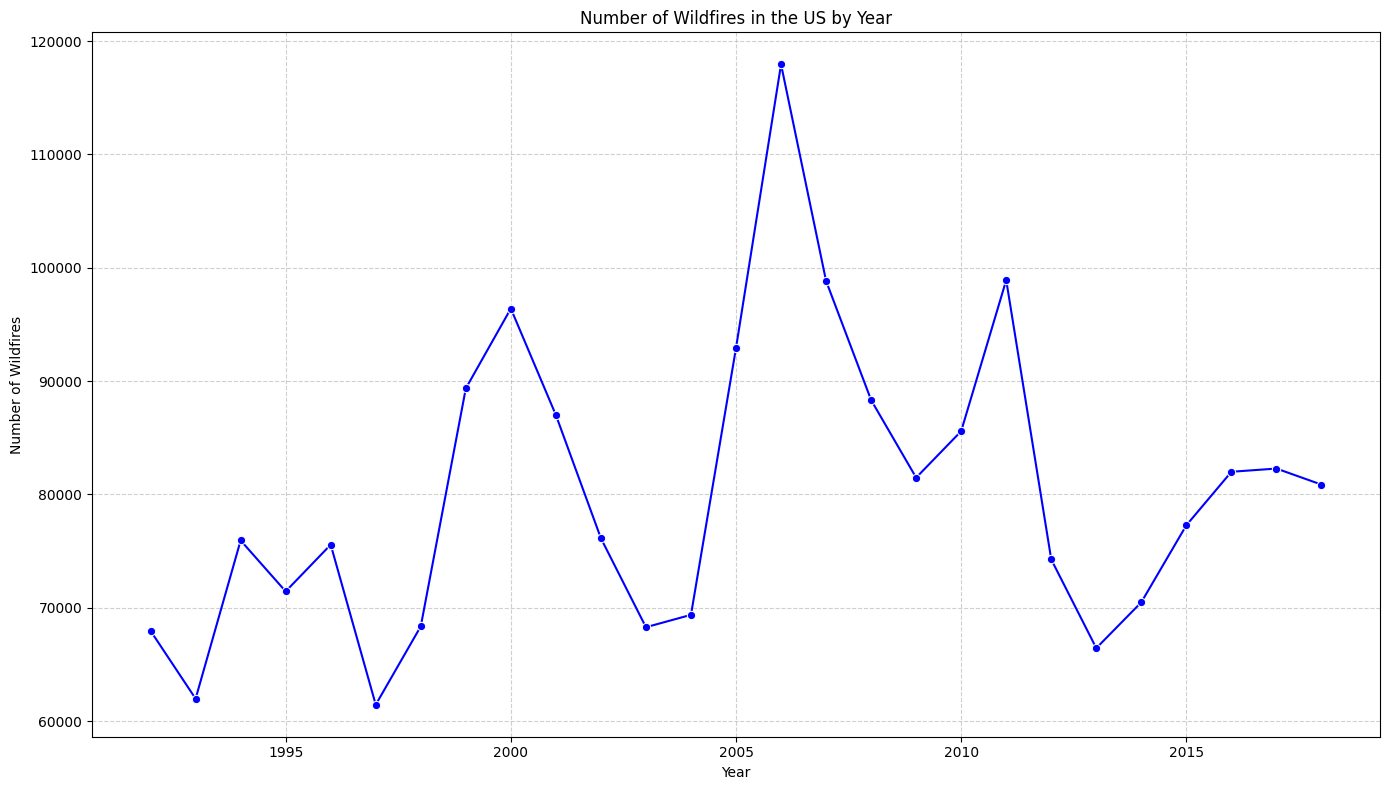

In [26]:
# Filter data for the US only
us_wildfires_by_year = wildfires_by_year_country[wildfires_by_year_country['COUNTRY'] == 'United States']

plt.figure(figsize=(14, 8))
sns.lineplot(data=us_wildfires_by_year, x='START_YEAR', y='Number of Wildfires', marker='o', color='blue')
plt.title('Number of Wildfires in the US by Year')
plt.xlabel('Year')
plt.ylabel('Number of Wildfires')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [27]:
display(us_wildfires_by_year)

,START_YEAR,COUNTRY,Number of Wildfires
48,1992,United States,67961
50,1993,United States,61972
52,1994,United States,75935
54,1995,United States,71440
56,1996,United States,75561
58,1997,United States,61442
60,1998,United States,68356
62,1999,United States,89350
64,2000,United States,96397
66,2001,United States,87001


Separate Plots are needed here.

Out of curiousity, I want to display the max for both countries.

In [28]:
display(wildfires_by_year_country.loc[wildfires_by_year_country.groupby('COUNTRY')['Number of Wildfires'].idxmax()])

,START_YEAR,COUNTRY,Number of Wildfires
44,1989,Canada,12014
76,2006,United States,117944


So we can see that the year with the most wildfires for Canada was 1989 with 12014 wildfires, and for the US it was 2006 with 117944 wildfires. Note that the number of wildfires refers to the number of wildfires reported during the year (not when they were put out).

I am considering restricting my models to the years 1992 - 2017, as the US data goes from 1992 to 2017. Based on the graph, this should be fine to do for creating a model.

In [29]:
lim_model_df = df_ex[(df_ex['START_YEAR'] >= 1992) & (df_ex['START_YEAR'] <= 2017)]
lim_model_df['START_YEAR'].unique()

array([2005., 2004., 2006., 2008., 2002., 2007., 2009., 2001., 2003.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017.])

In [30]:
lim_model_df.head()

,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,COUNTRY,CAUSE,DURATION,START_MONTH,START_YEAR,END_MONTH,END_YEAR
0,0.10,A,40.036944,-121.005833,United States,Human,0.0,2.0,2005.0,2.0,2005.0
1,0.25,A,38.933056,-120.404444,United States,Natural,0.0,5.0,2004.0,5.0,2004.0
2,0.10,A,38.984167,-120.735556,United States,Human,0.0,5.0,2004.0,5.0,2004.0
3,0.10,A,38.559167,-119.913333,United States,Natural,5.0,6.0,2004.0,7.0,2004.0
4,0.10,A,38.559167,-119.933056,United States,Natural,5.0,6.0,2004.0,7.0,2004.0


As per iteration one, my job is to apply predictive modeling for fire occurrence or intensitity. With the predictors I have at hand, this will be a difficult task. Still, I can predict intensitity via FIRE_SIZE_CLASS as the y, and occurence with the number of fires per year.

For the number of fires per year, it seems like for Canada that it hovers around 6000 wildfires per year. For the US, it seems to follow a cycle. I doubt we have the data to properly measure that cycle, unfortunately.
In either case, I do not think we have the means to predict them fairly.

I wouldn't keep it as a predictive model, but logistic regression could be performed on cause. Worth trying.

However, wildfire intensity is something we can predict. We could attempt to predict the class using the cause, start, month, and maybe duration as possible input variable. Lat and Long could be fun too. Metrics would be Accuracy, Recall, and ROC-AUC.

In [31]:
lim_model_df['CAUSE'].unique()

array(['Human', 'Natural', 'Missing data/not specified/undetermined'],
      dtype=object)

Before any models, we need to remove missing values.

In [32]:
lim_model_df = lim_model_df.dropna()

In [33]:
lim_model_mis_df = lim_model_df[lim_model_df['CAUSE'] != 'Missing data/not specified/undetermined']

In [34]:
print(len(lim_model_df), len(lim_model_mis_df))

1369070 1302368


1.3 million observations is still solid

In [35]:
from sklearn import linear_model

In [36]:
lim_model_x = lim_model_mis_df.drop(columns=['FIRE_SIZE_CLASS', 'FIRE_SIZE'])
lim_model_x.head()

,LATITUDE,LONGITUDE,COUNTRY,CAUSE,DURATION,START_MONTH,START_YEAR,END_MONTH,END_YEAR
0,40.036944,-121.005833,United States,Human,0.0,2.0,2005.0,2.0,2005.0
1,38.933056,-120.404444,United States,Natural,0.0,5.0,2004.0,5.0,2004.0
2,38.984167,-120.735556,United States,Human,0.0,5.0,2004.0,5.0,2004.0
3,38.559167,-119.913333,United States,Natural,5.0,6.0,2004.0,7.0,2004.0
4,38.559167,-119.933056,United States,Natural,5.0,6.0,2004.0,7.0,2004.0


In [37]:
lim_model_x_reduce = lim_model_x.drop(columns=['END_MONTH', 'END_YEAR', 'LATITUDE', 'LONGITUDE'])
lim_model_x_reduce.head()

,COUNTRY,CAUSE,DURATION,START_MONTH,START_YEAR
0,United States,Human,0.0,2.0,2005.0
1,United States,Natural,0.0,5.0,2004.0
2,United States,Human,0.0,5.0,2004.0
3,United States,Natural,5.0,6.0,2004.0
4,United States,Natural,5.0,6.0,2004.0


In [38]:
lim_model_cat_y = lim_model_mis_df['FIRE_SIZE_CLASS']
lim_model_cat_y.head()

,FIRE_SIZE_CLASS
0,A
1,A
2,A
3,A
4,A


In [39]:
lim_model_num_y = lim_model_mis_df['FIRE_SIZE']
lim_model_num_y.head()

,FIRE_SIZE
0,0.10
1,0.25
2,0.10
3,0.10
4,0.10


For a categorical y we have the classes, for numerical y we have the size in acres.

For linear model, we must use one-hot encoding for country and cause.

In [40]:
lim_model_x_hot = pd.get_dummies(lim_model_x_reduce, columns=['COUNTRY', 'CAUSE'], drop_first= True)
lim_model_x_hot['COUNTRY_United States'] = lim_model_x_hot['COUNTRY_United States'].astype(int)
lim_model_x_hot['CAUSE_Natural'] = lim_model_x_hot['CAUSE_Natural'].astype(int)
lim_model_x_hot.head()

,DURATION,START_MONTH,START_YEAR,COUNTRY_United States,CAUSE_Natural
0,0.0,2.0,2005.0,1,0
1,0.0,5.0,2004.0,1,1
2,0.0,5.0,2004.0,1,0
3,5.0,6.0,2004.0,1,1
4,5.0,6.0,2004.0,1,1


Now the one-hot encoding is done. We can now make the model.

In [41]:
mymodel = linear_model.LinearRegression()
mymodel.fit(lim_model_x_hot, lim_model_num_y)

LinearRegression()

In [42]:
print(mymodel.coef_)
print(mymodel.intercept_)
print(mymodel.score(lim_model_x_hot, lim_model_num_y))

[   1.88235145  -12.72587934    4.05537118 -941.25158438  550.74071221]
-7127.437109236005
0.0043346662765966215


Very, very poor model. This does make sense - a linear approach was unlikely to bear fruit.

I don't think any model besides maybe random forest for cause will justify cross-validation. I think that is the only one worth doing here.

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
mymodelRF = RandomForestClassifier(n_estimators=40)
mymodelRF.fit(lim_model_x_hot, lim_model_cat_y)

RandomForestClassifier(n_estimators=40)

In [45]:
print(mymodelRF.score(lim_model_x_hot, lim_model_cat_y))

0.5623602545517089


Even when training the random forest on the full dataset (not advised to do), it still only has a middling score. That said, it is high enough to justify a proper cross-validation...maybe

In [46]:
print("\nFire Size Class Distribution by Country:")
mymodel_dat = lim_model_df.groupby('COUNTRY')['FIRE_SIZE_CLASS'].value_counts(normalize=True).unstack(fill_value=0)
display(mymodel_dat)


Fire Size Class Distribution by Country:


FIRE_SIZE_CLASS,A,B,C,D,E,F,G
COUNTRY,,,,,,,
Canada,0.469690,0.369341,0.078569,0.021151,0.01747,0.019941,0.023840
United States,0.419756,0.439266,0.108009,0.015846,0.00878,0.005400,0.002943


0.56 accuracy is not good at all. One could get about 0.45 just by predicting the most common class by country.